In [1]:
import qutip as qt
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import pickle

import matplotlib.ticker as ticker


from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm
from scipy.integrate import simpson

%matplotlib inline

# Setup matplotlib

In [2]:



plt.rcParams.update({
    "text.usetex": True,
    #"text.latex.preamble": r"\boldmath",
    #"font.family": "sans-serif",
    #"mathtext.fontset" : "stix",
    "font.family" : "lmodern", #   "font.serif": ["Times New Roman"],
    "font.weight": "bold",
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #"text.latex.preamble": r"\usepackage[T1]{fontenc}  \usepackage[utf8]{inputenc} \usepackage{amsmath} \usepackage{mathptmx}\usepackage{amsfonts}",
    #
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.4,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.4,     # distance to the minor tick label in points
    #
    "xtick.major.size": 5.5, 
    "ytick.major.size": 5.5,
    
    "xtick.minor.size": 3.5, 
    "ytick.minor.size": 3.5,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "white",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})



# Spectrum related functions

In [3]:
### Functions for evaluating the dominant eigenvalue

def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], np.conjugate(e_mat)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], e_mat/np.trace(e_mat)
        
    else: raise ValueError('You have to choose or left or right')

###############
####### Coding 
###############

# Differential equation functions

In [4]:

def Apply_Tilted_lindblad_normed(t, rho, args):
    """
    Apply the tilted Lindblad equation to a density matrix.

    Parameters:
    t: float
        Time at which the Lindblad equation is evaluated.
    rho: array-like
        The density matrix at time t, flattened to a 1D array.
    args: dictionary
        Additional arguments required for the tilted Lindblad operator.

    Returns:
    drho: array-like
        The time derivative of the density matrix, flattened to a 1D array.
    """
    
    # Compute the time derivative of rho using the tilted Lindblad operator
    drho = Tilted_lindbladian(t, args) @ rho
    
    drho = drho - rho * np.trace(np.reshape(drho, (2,2)))

    # Return the time derivative of rho, flattened back to a 1D array
    return drho


def Apply_Tilted_lindblad(t, rho, args):
    """
    Apply the tilted Lindblad equation to a density matrix.

    Parameters:
    t: float
        Time at which the Lindblad equation is evaluated.
    rho: array-like
        The density matrix at time t, flattened to a 1D array.
    args: dictionary
        Additional arguments required for the tilted Lindblad operator.

    Returns:
    drho: array-like
        The time derivative of the density matrix, flattened to a 1D array.
    """
    
    # Compute the time derivative of rho using the tilted Lindblad operator
    drho = Tilted_lindbladian(t, args) @ rho
    
    # Return the time derivative of rho, flattened back to a 1D array
    return drho

# Get exact diagonalization

In [5]:

def get_exact_diagonalization(tlist, H, Lm, args):
    #### Exact diagonalization 
    e_vals = []
    e_vecs = []

    for t in tlist:
        Ws = Tilted_lindbladian(t, args)
        e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
        e_vals.append(e_val)
        e_vecs.append(qt.Qobj(e_vec))
    
    return e_vecs

# Model

In [6]:
####
#### Vectorized tilted operator
####

def Tilted_lindbladian(t, args):

    H = args["H"]
    Lm = args["Lm"] 
    H0 = H[0] 
    H1 = H[1][0]

    driving_t = H[1][1]

    Ide = qt.qeye(2)

    Flat_H0    = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()  

    Flat_H1    = -1.0j*(qt.tensor(Ide, H1) - qt.tensor(H1.trans(), Ide)).full()  

    Flat_inco_m = -(1.0/2.0)*(qt.tensor(Ide, Lm.dag()*Lm) + qt.tensor((Lm.dag()*Lm).trans(), Ide)).full()

    Flat_jump_m = (qt.tensor(Lm.conj(),Lm)).full()

       
    Wst = (Flat_H0 * args["omega"]
         + Flat_H1 * driving_t(t, args)
         + Flat_inco_m * args["gamma"] 
         + Flat_jump_m * args["gamma"] * np.exp(-args["s"]))

    return Wst.astype(complex)
              

# Instantaneous Fidelity 

In [7]:
##
## Fig a) 
##

def get_Fidelity_tau(rho0, H, Lm, taulist=[1, 10, 100]): 
    Fidelity_list = []
    Tlist_list = []
    rho0_int = np.array(rho0,dtype=np.complex_).flatten()

    for tau in taulist:
        tlist = np.linspace(0, tau, Nsteps)
        args["tau"] = tau
        args_int = (args, )
        t_span = (0, tau)

        sol = solve_ivp(Apply_Tilted_lindblad_normed, 
                (0, tau), 
                rho0_int, 
                t_eval=tlist, 
                args=(args, ), 
                method="DOP853",
                rtol=1e-12, 
                atol=1e-14)

        print(sol.success, sol.status)
        e_vals = []
        e_vecs = []
        for t in tlist:
            Ws = Tilted_lindbladian(t, args)
            e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
            e_vals.append(e_val)
            e_vecs.append(qt.Qobj(e_vec))
    
        states_int = [qt.Qobj(state.reshape((2,2))) for state in sol.y.transpose()]

        Fidelity_list.append([qt.fidelity(states_int[i], e_vecs[i]) for i in range(Nsteps)])
        Tlist_list.append(tlist)
    return Tlist_list, Fidelity_list


# Integrated fidelity 

In [8]:

def Fidelity_taulist_s(rho0, tau_list, slist, args):

    rho0_int = np.array(rho0,dtype=np.complex_).flatten()
    
    Fidelity_taulist_s = []

    args_aux = args.copy() 

    for s in slist:
        
        Fidelity_taulist = []
        args_aux["s"] = s 
        
        for tau in tau_list:
    
            tlist = np.linspace(0, tau, args["Nsteps"])
            args_aux["tau"] = tau

            sol = solve_ivp(Apply_Tilted_lindblad_normed, 
                            (0, tau), 
                            rho0_int, 
                            t_eval=tlist, 
                            args= (args_aux, ), 
                            method="DOP853", 
                            rtol=1e-12, 
                            atol=1e-14)
            print("For tau= {:.3f}, the solver finished with {} and states {}".format(tau, sol.success, sol.status))
    
            evolved_rho = [qt.Qobj(sol.y.transpose()[i].reshape((2,2))) for i, t in enumerate(tlist)]
    
            Ws_list = [Tilted_lindbladian(t, args_aux) for t in tlist]
            e_vec_list = [Numeric_diagonalization(Ws, side="right")[1] for Ws in Ws_list]
            rho_list = [qt.Qobj(e_vec) for e_vec in e_vec_list]
    
            Fidelity_tlists = [qt.fidelity(rho_list[i], evolved_rho[i]) for i, t in enumerate(tlist)]
    
            Fidelity_taulist.append(simpson(Fidelity_tlists, tlist)/tau)

        print("End of {}\n".format(s))
        Fidelity_taulist_s.append(Fidelity_taulist)
    return Fidelity_taulist_s

# Evaluating Theta 

# Exact theta 

In [9]:
####
#### Evaluating numerically the exact theta
####

def get_Exact_theta(slist, args):
    
    exact_theta = []
    args_aux = args.copy()
    tlist = np.linspace(0, 1, args["Nsteps"])
    
    for i, s in enumerate(slist):
        print("{} out of {} - s = {:.3f} \n".format(i, len(slist), s))
        args_aux["tau"] = 1
        args_aux["s"] = s
        e_vals = []

        for t in tlist:
            Ws = Tilted_lindbladian(t, args_aux)
            e_val, e_vec =  Numeric_diagonalization(Ws, side="right")
            e_vals.append(e_val)

        exact_theta.append(simpson(e_vals, tlist))
    return np.array(exact_theta).real

# Theta for different taus 

In [15]:
def get_theta_tau(taulist, s_list, rho0, args): 

    
    rho0_int = np.array(rho0,dtype=np.complex_).flatten()
    args_aux = args.copy()
 
    Tlist_list = []
    thetas = []
    
    for tau in taulist:
        aux = []
        for s in s_list:
            tlist = np.linspace(0, tau, args_aux["Nsteps"])
            args_aux["tau"] = tau
            args_aux["s"] = s

            sol = solve_ivp(Apply_Tilted_lindblad, 
                    (0, tau), 
                    rho0_int, 
                    t_eval=[0, tau], 
                    args=(args_aux, ), 
                    method="DOP853", 
                    rtol=1e-12, 
                    atol=1e-14)
            print("tau = {:.1f}, s = {:.3f} - Solver: success= {}, status {}".format(
                                                                    tau, s, sol.success, sol.status))
            evolved_rho = qt.Qobj(sol.y.transpose()[-1].reshape((2,2)))
            aux.append((1/tau)*np.log(evolved_rho.tr()))
            
        Tlist_list.append(tlist)    
        thetas.append(aux)
    return Tlist_list, thetas 

# Driving 

In [11]:
def driving(t, args):

    if t < args["tau"]/2:
        return args["laser"]*np.cos(np.pi*(t/args["tau"]))
    else:
        return args["laser"]*np.sin(np.pi*(t/args["tau"]))


# Parameters 

In [12]:
H0 = (qt.qeye(2) + qt.sigmaz())/2
H1 = qt.sigmax()

Lm = qt.sigmam()

######## Parameters 

s = -0.5
laser = 1.0
omega = 0.0
gamma = 1.0

tau = 1
Nsteps = 1000
tlist = np.linspace(0, tau, Nsteps)

####### Hamiltonian and jumping operators 
H = [H0, [H1, driving]]

c_ops = [np.sqrt(gamma)*Lm]

###### Initial state 

rho0 = (1/2)*(qt.basis(2,0)+qt.basis(2,1))*(qt.basis(2,1).dag() + qt.basis(2,0).dag())

###### Arg dict 

args  = {"s":s,
         "laser":laser,
         "omega":omega,
         "gamma":gamma,
         "tau":tau,
         "H": H,
         "Lm":Lm,
         "Nsteps":Nsteps}


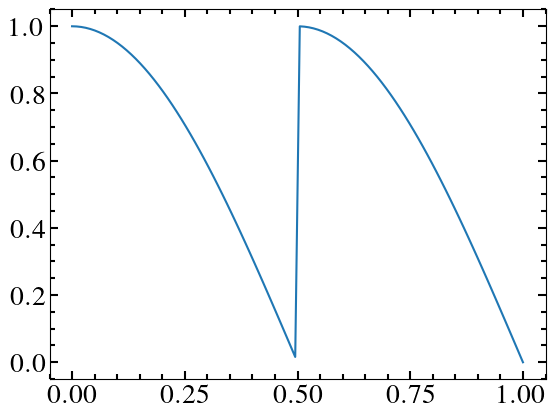

In [152]:
driving(1, args)
plt.plot(np.linspace(0, 1, 100), [driving(t, args) for t in np.linspace(0, 1, 100)]) 

# Fig 2-b

In [61]:

tau = 100
Nsteps = 1000
F2b_tlist = np.linspace(0, tau, Nsteps)
F2b_taulist=[0.1, 1, 10, 100]

F2b_tlist_list, F2b_fidelity_list = get_Fidelity_tau(rho0, H, Lm, taulist=F2b_taulist)

True 0
True 0
True 0
True 0


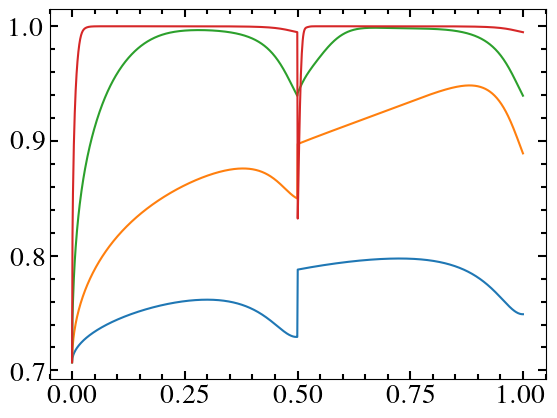

In [62]:
plt.plot(F2b_tlist_list[0]/F2b_tlist_list[0][-1], F2b_fidelity_list[0])
plt.plot(F2b_tlist_list[1]/F2b_tlist_list[1][-1], F2b_fidelity_list[1])
plt.plot(F2b_tlist_list[2]/F2b_tlist_list[2][-1], F2b_fidelity_list[2])
plt.plot(F2b_tlist_list[3]/F2b_tlist_list[3][-1], F2b_fidelity_list[3])

# Fig 2-a

In [26]:
F2a_slist = [-0.5, 0, 0.5]
F2a_tau_list = np.logspace(-2, np.log10(100), 200)

F2a_FTs = Fidelity_taulist_s(rho0, F2a_tau_list, F2a_slist, args)

For tau= 0.010, the solver finished with True and states 0
For tau= 0.010, the solver finished with True and states 0
For tau= 0.011, the solver finished with True and states 0
For tau= 0.011, the solver finished with True and states 0
For tau= 0.012, the solver finished with True and states 0
For tau= 0.013, the solver finished with True and states 0
For tau= 0.013, the solver finished with True and states 0
For tau= 0.014, the solver finished with True and states 0
For tau= 0.014, the solver finished with True and states 0
For tau= 0.015, the solver finished with True and states 0
For tau= 0.016, the solver finished with True and states 0
For tau= 0.017, the solver finished with True and states 0
For tau= 0.017, the solver finished with True and states 0
For tau= 0.018, the solver finished with True and states 0
For tau= 0.019, the solver finished with True and states 0
For tau= 0.020, the solver finished with True and states 0
For tau= 0.021, the solver finished with True and states

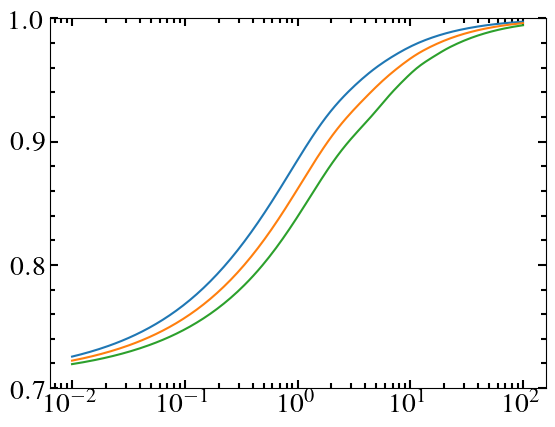

In [27]:
plt.plot(F2a_tau_list, F2a_FTs[0])
plt.plot(F2a_tau_list, F2a_FTs[1])
plt.plot(F2a_tau_list, F2a_FTs[2])

plt.ylim((0.7, 1))

plt.xscale("log")

# Fig 2-c

In [59]:
F2c_tau_list = [0.1, 1, 10, 100]
F2c_slist = np.linspace(-1.5, 1.5, 20)

F2c_exact_theta = get_Exact_theta(F2c_slist, args)

F2c_tlist_list, F2c_thetas = get_theta_tau(F2c_tau_list, F2c_slist, rho0, args)

0 out of 20 - s = -1.500 

1 out of 20 - s = -1.342 

2 out of 20 - s = -1.184 

3 out of 20 - s = -1.026 

4 out of 20 - s = -0.868 

5 out of 20 - s = -0.711 

6 out of 20 - s = -0.553 

7 out of 20 - s = -0.395 

8 out of 20 - s = -0.237 

9 out of 20 - s = -0.079 

10 out of 20 - s = 0.079 

11 out of 20 - s = 0.237 

12 out of 20 - s = 0.395 

13 out of 20 - s = 0.553 

14 out of 20 - s = 0.711 

15 out of 20 - s = 0.868 

16 out of 20 - s = 1.026 

17 out of 20 - s = 1.184 

18 out of 20 - s = 1.342 

19 out of 20 - s = 1.500 

tau = 0.1, s = -1.500 - Solver: success= True, status 0
tau = 0.1, s = -1.342 - Solver: success= True, status 0
tau = 0.1, s = -1.184 - Solver: success= True, status 0
tau = 0.1, s = -1.026 - Solver: success= True, status 0
tau = 0.1, s = -0.868 - Solver: success= True, status 0
tau = 0.1, s = -0.711 - Solver: success= True, status 0
tau = 0.1, s = -0.553 - Solver: success= True, status 0
tau = 0.1, s = -0.395 - Solver: success= True, status 0
tau = 0.1, s

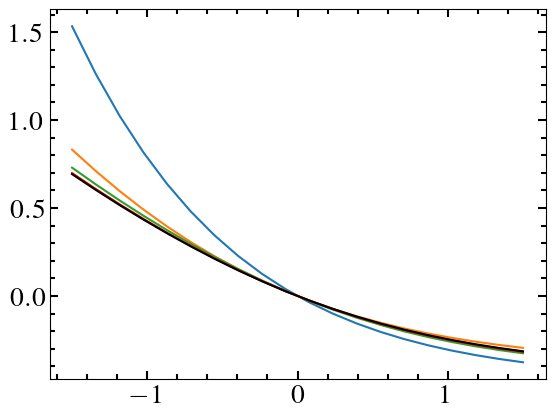

In [60]:
plt.plot(F2c_slist, np.real(F2c_thetas[0]))
plt.plot(F2c_slist, np.real(F2c_thetas[1]))
plt.plot(F2c_slist, np.real(F2c_thetas[2]))
plt.plot(F2c_slist, np.real(F2c_thetas[3]), color="red")

plt.plot(F2c_slist, np.array(F2c_exact_theta).real, color="black")

# Saving 

In [90]:
data = args.copy()

data.update({"F2a_tau_list":F2a_tau_list})
data.update({"F2a_slist":F2a_slist})
data.update({"F2a_FTs":F2a_FTs})


data.update({"F2b_tlist_list":F2b_tlist_list})
data.update({"F2b_fidelity_list":F2b_fidelity_list})

data.update({"F2c_tau_list":F2c_tau_list})
data.update({"F2c_slist":F2c_slist})
data.update({"F2c_tlist_list":F2c_tlist_list})
data.update({"F2c_thetas":F2c_thetas})
data.update({"F2c_exact_theta":F2c_exact_theta})

In [91]:
del data["H"]
del data["Lm"]

In [92]:
with open('DataFig2.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plotting 

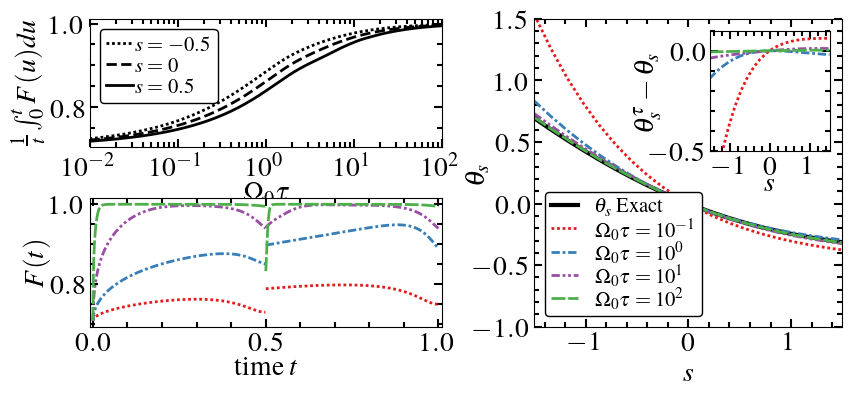

In [89]:
fig = plt.figure(figsize = (10,4))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:,1])



######
###### Fig 2a
######
ax1.plot(F2a_tau_list, F2a_FTs[0], color="black", linestyle=(0, (1, 1)), label=r"$s=-0.5$", linewidth=2)
ax1.plot(F2a_tau_list, F2a_FTs[1], color="black", linestyle="--", label=r"$s=0$", linewidth=2)
ax1.plot(F2a_tau_list, F2a_FTs[2], color="black", linestyle="-", label=r"$s=0.5$", linewidth=2)

ax1.set_xlabel(r"$\Omega_0\tau$", labelpad=0)
ax1.set_ylabel(r"$\frac{1}{t} \int_0^tF(u)du$")
ax1.set_xscale("log")


ax1.set_xticks([0.01, 0.1, 1, 10, 100])

ax1.tick_params(axis='x', pad=7)

#ax1.set_ylim((0.75, 1.01))
ax1.set_xlim((0.01, 100))

#ax1.legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=8, columnspacing=0.2, handletextpad=0.1, ncol=3)
ax1.legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=0, labelspacing=0.1, handletextpad=0.1)


######
###### Fig 2b
######


ax2.plot(F2b_tlist_list[0][:int(Nsteps/2)]/max(F2b_tlist_list[0]), F2b_fidelity_list[0][:int(Nsteps/2)], color="#e41a1c", label=r"$\Omega_0\tau=10^{-1}$", linestyle=(0, (1, 1)) , linewidth=2)
ax2.plot(F2b_tlist_list[1][:int(Nsteps/2)]/max(F2b_tlist_list[1]), F2b_fidelity_list[1][:int(Nsteps/2)], color="#377eb8", label=r"$\Omega_0\tau=10^0$", linestyle=(0,(3, 1, 1, 1)), linewidth=2)
ax2.plot(F2b_tlist_list[2][:int(Nsteps/2)]/max(F2b_tlist_list[2]), F2b_fidelity_list[2][:int(Nsteps/2)], color="#984ea3", label=r"$\Omega_0\tau=10^1$", linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
ax2.plot(F2b_tlist_list[3][:int(Nsteps/2)]/max(F2b_tlist_list[3]), F2b_fidelity_list[3][:int(Nsteps/2)], color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle=(0, (5, 1)), linewidth=2)

ax2.plot(F2b_tlist_list[0][int(Nsteps/2):]/max(F2b_tlist_list[0]), F2b_fidelity_list[0][int(Nsteps/2):], color="#e41a1c",linestyle=(0, (1, 1)) , linewidth=2)
ax2.plot(F2b_tlist_list[1][int(Nsteps/2):]/max(F2b_tlist_list[1]), F2b_fidelity_list[1][int(Nsteps/2):], color="#377eb8",linestyle=(0,(3, 1, 1, 1)), linewidth=2)
ax2.plot(F2b_tlist_list[2][int(Nsteps/2):]/max(F2b_tlist_list[2]), F2b_fidelity_list[2][int(Nsteps/2):], color="#984ea3",linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
ax2.plot(F2b_tlist_list[3][int(Nsteps/2):]/max(F2b_tlist_list[3]), F2b_fidelity_list[3][int(Nsteps/2):], color="#4daf4a",linestyle=(0, (5, 1)), linewidth=2)

ax2.set_xlabel(r"time $t$", labelpad=0)
ax2.set_ylabel(r"$F(t)$", labelpad=0)

ax2.set_xlim((-0.01, 1.01))

#ax2.legend(edgecolor="black", framealpha=1,handlelength=1.3, borderpad=0.3, fontsize=15, loc=4, labelspacing = 0.1)


#######################
######################
######################

ax3.plot(F2c_slist, np.array(F2c_exact_theta).real, color="black", label=r"$\theta_s$ Exact", linewidth=3)


ax3.plot(F2c_slist, np.array(F2c_thetas[0]).real,color="#e41a1c", label=r"$\Omega_0\tau=10^{-1}$", linestyle=(0, (1, 1)) , linewidth=2)
ax3.plot(F2c_slist, np.array(F2c_thetas[1]).real,color="#377eb8", label=r"$\Omega_0\tau=10^0$", linestyle=(0,(3, 1, 1, 1)), linewidth=2)
ax3.plot(F2c_slist, np.array(F2c_thetas[2]).real,color="#984ea3", label=r"$\Omega_0\tau=10^1$", linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
ax3.plot(F2c_slist, np.array(F2c_thetas[3]).real,color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle=(0, (5, 1)), linewidth=2)


ax3.set_xlabel(r"$s$")
ax3.set_ylabel(r"$\theta_s$", labelpad=-12)
ax3.set_ylim((-1,1.5))
ax3.set_xlim((-1.5,1.5))

ax3.set_box_aspect(1)


ax3.legend(edgecolor="black", framealpha=1, handlelength=1.3, borderpad=0.3, fontsize=15, loc=3, labelspacing=0.1)

left1, bottom1, width1, height1 = [0.63, 0.55, 0.35, 0.3]
ax31 = fig.add_axes([left1, bottom1, width1, height1])
ax31.set_box_aspect(1)

ax31.plot(F2c_slist, (np.array(F2c_exact_theta)-np.array(F2c_thetas[0])).real,color="#e41a1c", label=r"$\Omega_0\tau=10^{-1}$", linestyle=(0, (1, 1)) , linewidth=2)
ax31.plot(F2c_slist, (np.array(F2c_exact_theta)-np.array(F2c_thetas[1])).real,color="#377eb8", label=r"$\Omega_0\tau=10^{0}$", linestyle=(0,(3, 1, 1, 1)), linewidth=2)
ax31.plot(F2c_slist, (np.array(F2c_exact_theta)-np.array(F2c_thetas[2])).real,color="#984ea3", label=r"$\Omega_0\tau=10^{1}$", linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
ax31.plot(F2c_slist, (np.array(F2c_exact_theta)-np.array(F2c_thetas[3])).real,color="#4daf4a", label=r"$\Omega_0\tau=10^2$", linestyle=(0, (5, 1)), linewidth=2)

ax31.set_ylabel(r"$\theta_s^\tau - \theta_s$", labelpad=-8)

ax31.set_xlabel(r"$s$", labelpad=-6)

ax31.set_ylim((-0.5, 0.1))
ax31.set_xlim((-1.5, 1.5))





plt.subplots_adjust(hspace=0.4)


#plt.savefig("Fig2_test.pdf", bbox_inches="tight")


